First, we add all the necessary packages.

In [ ]:
using Pkg
Pkg.activate(".")
using PythonCall,CondaPkg
JEft=pyimport("justetf_scraping")

using CairoMakie, MakieShorthands
using Statistics, CovarianceEstimation
using LinearAlgebra, Dates, Serialization
using NLopt, JuMP



  Activating project at `~/Codes/portfolio`
    CondaPkg Found dependencies: /home/nikolay/Codes/portfolio/CondaPkg.toml
    CondaPkg Found dependencies: /home/nikolay/.julia/packages/PythonCall/Nr75f/CondaPkg.toml
    CondaPkg Dependencies already up to date


dist_name (generic function with 1 method)

The `shift` parameter gives a period of time in days over which all the returns will be evaluated. The `half_life` parameter controls the exponential distribution used in `weighted_mean`. The distribution is given by powers of $\lambda=(\frac{1}{2})^{1/(\mathrm{shift}*\mathrm{half\_life})}$, function `nrm` returns the normalization factor for this distribution depending on the length of the sequence.  

In [ ]:
shift=360
half_life=4;

percent_return(vals,shift)=(vals[1+shift:end]-vals[1:end-shift])./vals[1:end-shift]

function dist_name(nm::String)
    rules=(r"\(Acc\)$" => "(Dist)",r"\(acc\)$" => "(dist)", r"Acc$" => "Dist",  r"acc$" => "dist", r"A-acc$" => "A-dis", r"ETF$" => "ETF Distribution", r"ETF$" => "ETF Dist", r"Accumulating$"=>"Distributing", r"1C&"=>"1D")
    replace(nm, rules...)
end


λ=(1/2)^(1/(shift*half_life))
nrm(λ,k)=(1-λ^k)/(1-λ)

function weighted_mean(v)
    weights=reverse(λ.^(0:length(v)-1)./nrm(λ,length(v))) # we do reverse here as we want to give the highest weight to the most recent data    
    return sum(weights.*v)
end;


weighted_mean (generic function with 1 method)

Now, we load overview table. It contains some basic information about all tickers.

In [ ]:
overview_table=JEft.load_overview(strategy="epg-longOnly")
tickers=pyconvert(Array,overview_table.index);

/home/nikolay/Codes/portfolio/.CondaPkg/env/lib/python3.11/site-packages/justetf_scraping/overview.py:407: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace({"Yes": True, "No": False}).astype("bool")
/home/nikolay/Codes/portfolio/.CondaPkg/env/lib/python3.11/site-packages/justetf_scraping/overview.py:407: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace({"Yes": True, "No": False}).astype("bool")


3296-element Vector{Py}:
 'IE00B5BMR087'
 'IE00B4L5Y983'
 'IE00B3XXRP09'
 'IE00B3YCGJ38'
 'IE00BKM4GZ66'
 'IE0031442068'
 'IE00BFMXXD54'
 'IE00B4ND3602'
 'IE00B579F325'
 'IE00B6R52259'
 ⋮
 'DE000ETC0001'
 'DE000ETC0779'
 'DE000ETC0746'
 'IE000LZC9NM0'
 'IE000GETKIK8'
 'IE000XIITCN5'
 'XS2651539681'
 'GB00BRXHQ425'
 'LU2009147591'

Now, we load all charts from https://www.justetf.com/. This may take a bit of time as the website sometimes throws "429". After data is loaded it will be saved in "./data". Next time this cell runs, it will simply deserialize the data from "./data". We load "relative_with_reinvested_dividends" data, it gives the ticker price in % from the initial price and assumes that all the dividents were reinvested into the same ticker. This is what "accumulating" etf's do.  

In [7]:
mkpath("data")
pr_tmp=x->percent_return(x,shift)

if !isfile("data/tickers")
    i=1

    dates=Vector{DateTime}[]
    vals=Vector{Float64}[]    
    returns=Vector{Float64}[]


    while i<=length(tickers)
        tk=tickers[i]
        try 
            chart=JEft.load_chart(tk)["relative_with_reinvested_dividends"]

            dates_chart=pyconvert(Vector,chart.index)
            vals_chart=100 .+pyconvert(Vector,chart.values) 

            push!(dates,dates_chart)
            push!(vals,vals_chart)
            
            println(tk, " : ($i out of $(length(tickers))) done")
            i+=1
        catch e
            if e==InterruptException()
                throw(e)
            else
                println(e)
                println("Will sleep for 5 minutes and try again.")
                sleep(60*5)
            end
        end
    end

    serialize("data/tickers", tickers)
    serialize("data/dates", dates)
    serialize("data/values", vals)

end

tickers_all=deserialize("data/tickers")
dates_all=deserialize("data/dates")
vals_all=deserialize("data/values")
returns_all=pr_tmp.(vals_all);

ticker_to_index=(enumerate(tickers_all) .|> x->(x[2],x[1])) |> Dict;


In the following cell we first restrict ourself to some subset of ETFs by truncating the `overview_table` here I require: capital of more than 50 millions euro, accumulating EFT. We also replace the data of some accumulating ETFs with their distributing counterparts as they have more data while behaving in the same way. 

In [8]:
df=overview_table[overview_table["size"]>50]
df=df[df["dividends"]==Py("Accumulating")]
#df=df[df["currency"]==Py("EUR")]

tickers=pyconvert(Array,df.index)

for i=1:length(tickers)
    i_in_all=ticker_to_index[tickers[i]]

    nm=df["name"][tickers[i]]
    nmd=dist_name(pyconvert(String,nm))

    try
        i_in_all_d=ticker_to_index[pyconvert(Array,overview_table[overview_table["name"]==Py(nmd)].name.index)[1]]

        if (length(vals_all[i_in_all])<length(vals_all[i_in_all_d])) && (length(vals_all[i_in_all])<360*5)
            vals_all[i_in_all]=vals_all[i_in_all_d]
            dates_all[i_in_all]=dates_all[i_in_all_d]
            returns_all[i_in_all]=returns_all[i_in_all_d]
            println("$(tickers[i]) data is replaced with $(tickers_all[i_in_all_d]) data")
        end

    catch e
    end
end

IE000XZSV718 data is replaced with IE00B6YX5C33 data
IE00BMYHQM42 data is replaced with IE00B3S5XW04 data
IE00BL6K8D99 data is replaced with IE000FOSCLU1 data
IE000RHYOR04 data is replaced with IE00BCRY6557 data
LU1407887915 data is replaced with LU1407888053 data
IE00BDR55471 data is replaced with IE00BDR55364 data
FR0014003N93 data is replaced with FR0011660927 data
IE000AK4O3W6 data is replaced with IE00BYZTVV78 data
IE0000UJ3480 data is replaced with IE0000VITHT2 data
IE00BMVB5P51 data is replaced with IE00BMVB5Q68 data
IE0008UEVOE0 data is replaced with IE000264WWY0 data
IE000F6G1DE0 data is replaced with IE00B4L60045 data
IE000WA6L436 data is replaced with IE000SIZJ2B2 data
LU0959211326 data is replaced with LU0959211243 data
IE00BKPSFD61 data is replaced with IE00BYPC1H27 data
IE000MAO75G5 data is replaced with IE00B1YZSC51 data
IE000589MF42 data is replaced with IE00B7LW6Y90 data
IE000JXFRNI0 data is replaced with IE00BDQYWQ65 data
FR0014003IY1 data is replaced with FR001031577

Now, we define `dates, vals, returns` and `ticker_to_index` which contain information only about the accumulating ETFs.

In [9]:
chosen_indices=Int[]
for tk in tickers
    push!(chosen_indices, ticker_to_index[tk])
end

dates=dates_all[chosen_indices]
vals=vals_all[chosen_indices]
returns=returns_all[chosen_indices];
ticker_to_index=(enumerate(tickers) .|> x->(x[2],x[1])) |> Dict;

Let us take a random ticker and plot its behavior to compare with the website.

ticker: IE000U99N3V1


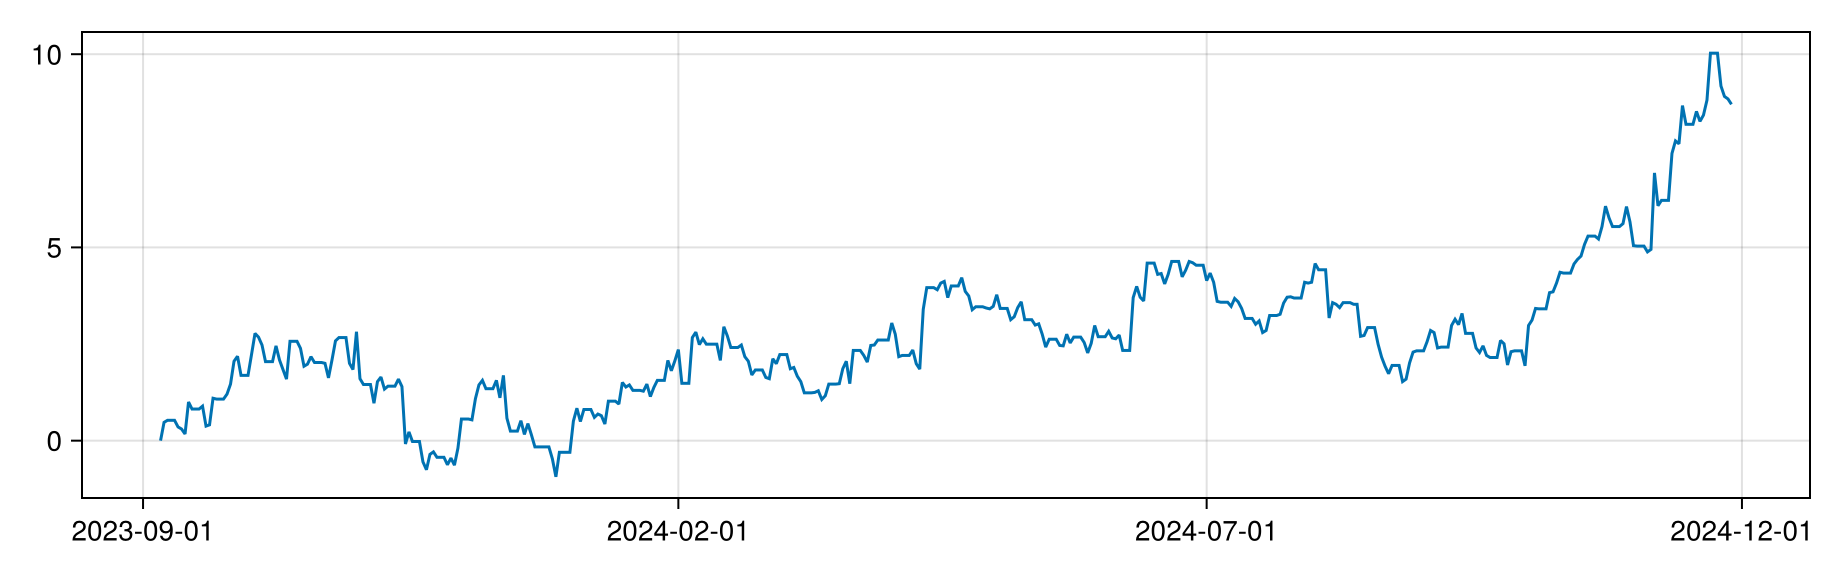

In [10]:
i=rand(1:length(tickers))
println("ticker: ", tickers[i])
fig=Figure(;size=(921,288))
ax=Axis(fig[1,1])
lines!(ax,dates[i],vals[i].-100)
fig

There are some tickers with not enough data, we are throwing them away below. We will use only tickers with more than 5 years of recorded data. We also filter some tickers that may be not accessible through the given broker.

In [11]:
old_len=length(tickers)

filter=(dates .|> x->x[1]).<=DateTime(2019)

unaccessible_tickers=[Py("DE000EWG2LD7"), Py("DE000A0S9GB0"), Py("DE000EWG0LD1")]

for tk in unaccessible_tickers
    indx=ticker_to_index[tk]
    filter[indx]=0
end

tickers=tickers[filter]
dates=dates[filter]
vals=vals[filter]
returns=returns[filter]
ticker_to_index=(enumerate(tickers) .|> x->(x[2],x[1])) |> Dict;


println("Tickers number $old_len reduced to $(length(tickers))")

Tickers number 1235 reduced to 702


Below, we trim `returns`. We find the period in time in which all of our tickers have data. Then, we restrict `returns` to this period. This is needed for the computation of the covariance matrix.

In [12]:
last_day=findmin(dates .|> x->x[end])[1]
first_day=findmax(dates .|> x->x[1])[1]
println("data between $(first_day) and $(last_day) will be used")

dates_trimmed=copy(dates)
returns_trimmed=copy(returns)

for i in 1:length(tickers)
    first=findfirst(x->x==first_day,dates_trimmed[i])
    last=findfirst(x->x==last_day,dates_trimmed[i])
    dates_trimmed[i]=dates_trimmed[i][first:last]
    returns_trimmed[i]=returns_trimmed[i][first:last-shift]
end

data between 2018-12-14T00:00:00 and 2024-11-26T00:00:00 will be used


Now, we will reduce the number of tickers further by dividing them into highly correlated groups and choosing only one ticker from each group (the one with the highest sharpe ratio). For this, we will need compute the expectation values `R` and covariance matrix `RR` of the annual returns. We also compute the correlation matrix `cor`, which is a normalized version of the covariance matrix. We will use `cor` to distinguish the correlated assets. 

In [20]:
returns_mat=zeros(length(tickers),length(returns_trimmed[1]))
for i=1:length(tickers)
    returns_mat[i,:].=returns_trimmed[i]
end

target = DiagonalUnitVariance()
shrinkage=:lw
method = LinearShrinkage(target, shrinkage)

RR=cov(method, returns_mat; dims=2)
cor=diagm(sqrt.(diag(RR)).^(-1))*RR*diagm(sqrt.(diag(RR)).^(-1))

R=weighted_mean.(returns);

We have now correlation matrix, let us look at how tickers with correlations above certain threshold behave.

correlated tickers: 151


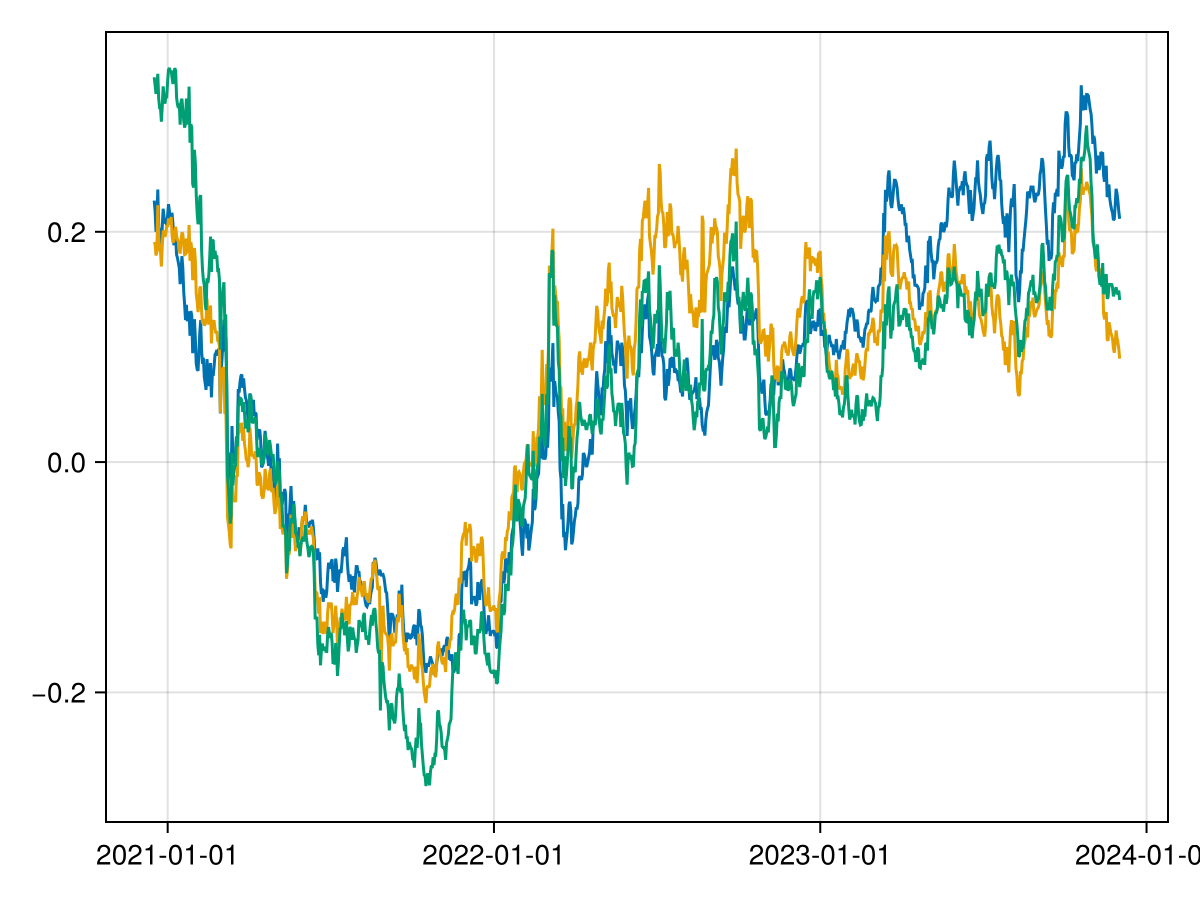

In [73]:
correlation_threshold=0.8
nyears=3
nsample=3

i=rand(1:length(tickers))
cor_tmp=cor[:,i]
fig=Figure()
ax=Axis(fig[1,1])

println("correlated tickers: ", length(returns_trimmed[cor_tmp.>correlation_threshold]))

returns_samples=rand(returns_trimmed[cor_tmp.>correlation_threshold],nsample)

for tk in returns_samples
    lines!(ax,dates_trimmed[1][end-360*(nyears+1):end-360], tk[end-360*nyears:end])
end
fig

The cell below runs the cleaning procedure

In [77]:
correlation_threshold=0.75
while length(cor[cor.>correlation_threshold])>size(cor,1)
    returns_mat=zeros(length(tickers),length(returns_trimmed[1]))
    for i=1:length(tickers)
        returns_mat[i,:].=returns_trimmed[i]
    end
    
   
    target = DiagonalUnitVariance()
    shrinkage=:lw
    method = LinearShrinkage(target, shrinkage)

    RR=cov(method, returns_mat; dims=2)
    cor=diagm(sqrt.(diag(RR)).^(-1))*RR*diagm(sqrt.(diag(RR)).^(-1))

    R=weighted_mean.(returns);

    correlated_tmp=Py[]
    for i=1:length(tickers)
        tmp=cor[i,:]
        if length(tickers[tmp.>correlation_threshold])>1
            correlated_tmp=tickers[tmp.>correlation_threshold]
            break
        end
    end
    
    if length(correlated_tmp)==0
        break
    end

    sharpe_ratios=[]
    for tk=correlated_tmp
        i=ticker_to_index[tk]
        push!(sharpe_ratios,(R[i]-0.0325)/(sqrt(RR[i,i])))
    end
    best_ticker_tmp_ind=findmax(sharpe_ratios)[2]

    best_ticker_tmp=correlated_tmp[best_ticker_tmp_ind]
    deleteat!(correlated_tmp,best_ticker_tmp_ind)
    filter=ones(Bool, length(tickers))
    for i =1:length(tickers)
        if tickers[i] ∈ pylist(correlated_tmp)
            filter[i]=0
        end
    end

    tickers=tickers[filter]
    dates=dates[filter]
    dates_trimmed=dates_trimmed[filter]
    vals=vals[filter]
    returns=returns[filter]
    returns_trimmed=returns_trimmed[filter]
    ticker_to_index=(enumerate(tickers) .|> x->(x[2],x[1])) |> Dict;

    println(size(cor,1))
end

35
33
30
29
28
27


I pushed the threshold down until I have only one ticker with gold because, well, if gold is not considered to be correlated with itself then nothing is. Finally, we have our short-list of the tickers. Le tus look at them. 

In [78]:
for i = 1:length(tickers)
    tk=tickers[i]
    println(overview_table.loc[tk].loc["name"])
end

iShares S&P 500 Information Technology Sector UCITS ETF USD (Acc)
Gold Bullion Securities
iShares USD TIPS UCITS ETF USD (Acc)
WisdomTree Physical Silver
Xtrackers CSI 300 Swap UCITS ETF 1C
iShares Bloomberg Roll Select Commodity Swap UCITS ETF USD
VanEck Global Mining UCITS ETF A
Lyxor Smart Overnight Return UCITS ETF C-GBP
WisdomTree Physical Platinum
iShares Nasdaq US Biotechnology UCITS ETF
Invesco US Health Care Sector UCITS ETF
iShares MSCI Japan USD Hedged UCITS ETF (Acc)
Xtrackers Japan Government Bond UCITS ETF 1C
Xtrackers Nifty 50 Swap UCITS ETF 1C
Xtrackers MSCI Europe Health Care ESG Screened UCITS ETF 1C
Invesco US Utilities Sector UCITS ETF
PIMCO Emerging Markets Advantage Local Bond Index UCITS ETF Acc
Amundi Floating Rate USD Corporate ESG UCITS ETF EUR Hedged (C)
WisdomTree Physical Precious Metals
UBS ETF (LU) Bloomberg US Liquid Corporates 1-5 Year UCITS ETF (hedged to CHF) A-acc
Amundi MSCI Turkey UCITS ETF Acc
SPDR MSCI Europe Utilities UCITS ETF
UBS ETF (LU) SBI 

The next cell computes covariance matrix and average returns again.

In [79]:
returns_mat=zeros(length(tickers),length(returns_trimmed[1]))
for i=1:length(tickers)
    returns_mat[i,:].=returns_trimmed[i]
end

target = DiagonalUnitVariance()
shrinkage=:lw
method = LinearShrinkage(target, shrinkage)
RR=cov(method, returns_mat; dims=2)

cor=diagm(sqrt.(diag(RR)).^(-1))*RR*diagm(sqrt.(diag(RR)).^(-1))

R=weighted_mean.(returns)

26-element Vector{Float64}:
  0.2629381220255467
  0.09722948631558685
  0.03466372578502937
  0.08453469746839422
  0.057952290958337524
  0.11163150260598276
  0.11564213158375385
  0.016621341406229336
  0.001968224926889502
  0.06480675804151617
  ⋮
  0.011626046362818979
  0.06254337005296579
  0.013259358204259475
  0.10615381829445776
  0.07060593123086494
  0.024853359401930706
 -0.21661572007908905
  0.0774991067643667
  0.04860172373322042

In [80]:
println("symmetric: ",(RR-RR' |> norm)==0)
RReig=eigvals(RR)
println("positive: ", all(RReig.>0))

symmetric: true
positive: true


Covariance matrix is symmetric and positive definite, as it should be. Now, let us proceed to the optimization. 

In [ ]:
USD_filter=pyconvert(Array,(df.loc[pylist(tickers)].currency==Py("USD")).values)
Banned_filter=zeros(Bool, length(tickers))

risk_free_return=0.0325
entropy_factor=0.24

USD_bound=0.6

function entropy(w)
    -sum((w).*log.(w))
end
function sharpe_ratio(w) 
    return (dot(R,w)-risk_free_return)/sqrt(dot(w,RR*w))
end
function objective(w)
    return sharpe_ratio(w)+entropy_factor*entropy(w)
end

model=Model(NLopt.Optimizer)
@variable(model, 0<=w[1:length(tickers)]<=1)
@objective(model,Max,objective(w))
@constraint(model, sum(w)==1)
@constraint(model, sum(w[USD_filter])<=USD_bound)
@constraint(model, sum(w[Banned_filter])<=1e-10)


#set_attribute(model, "algorithm", :LD_SLSQP)
set_attribute(model, "algorithm", :GN_ISRES)
set_attribute(model, "constrtol_abs", 1e-8)
set_attribute(model, "ftol_rel", 1e-8)

w0=rand(length(tickers))
w0/=sum(w0)
set_start_value.(w, w0)

JuMP.optimize!(model)

if !is_solved_and_feasible(model)
    throw("Optimizer did not find a solution!")
end

println("termination status: ", termination_status(model))

w_opt=value.(w)
sr0=dot(R,w_opt)/sqrt(dot(w_opt,RR*w_opt))

println(raw_status(model), "| objective: ", objective_value(model), " entropy: ", entropy(w_opt), " return: ", dot(R,w_opt), " risk: ", sqrt(dot(w_opt,RR*w_opt)), " return/risk ratio: ", sr0)

termination status: LOCALLY_SOLVED
XTOL_REACHED| objective: 2.26642786910606 entropy: 2.2910233637766666 return: 0.11866133272750214 risk: 0.05019353551817014 return/risk ratio: 2.364076001072818


In [249]:
ticker_names=pyconvert(Array,overview_table.loc[pylist(tickers)]["name"].values)
p=sortperm(w_opt; rev=true)
ticker_names_ordered=ticker_names[p]
w_opt_ord=w_opt[p]
for i = 1:length(w_opt)
    println(ticker_names_ordered[i], " : ", round(w_opt_ord[i]*100; digits=2),"%")
end

iShares S&P 500 Information Technology Sector UCITS ETF USD (Acc) : 25.81%
Amundi MSCI Turkey UCITS ETF Acc : 15.74%
iShares Bloomberg Roll Select Commodity Swap UCITS ETF USD : 11.78%
Gold Bullion Securities : 10.41%
SPDR MSCI Europe Utilities UCITS ETF : 7.5%
Amundi S&P 500 VIX Futures Enhanced Roll UCITS ETF Acc : 5.68%
Invesco US Health Care Sector UCITS ETF : 5.63%
UBS ETF (LU) SBI Foreign AAA-BBB 1-5 ESG UCITS ETF (CHF) A-acc : 4.95%
iShares MSCI Japan USD Hedged UCITS ETF (Acc) : 3.11%
UBS ETF (LU) Bloomberg US Liquid Corporates 1-5 Year UCITS ETF (hedged to CHF) A-acc : 2.12%
Xtrackers CSI 300 Swap UCITS ETF 1C : 2.07%
Amundi Floating Rate USD Corporate ESG UCITS ETF EUR Hedged (C) : 1.76%
iShares MSCI Mexico Capped UCITS ETF (Acc) : 1.2%
Xtrackers MSCI Europe Consumer Staples ESG Screened UCITS ETF 1C : 1.15%
Xtrackers MSCI Europe Health Care ESG Screened UCITS ETF 1C : 1.11%
Xtrackers Japan Government Bond UCITS ETF 1C : 0.0%
iShares Nasdaq US Biotechnology UCITS ETF : 0.0%
L

In [229]:
Banned_filter=w_opt.<5e-3

26-element BitVector:
 0
 0
 1
 1
 0
 0
 1
 1
 1
 1
 ⋮
 0
 1
 0
 0
 0
 0
 0
 0
 0

Well, let us hee how this performs on the historical data.

0.0985953814658547


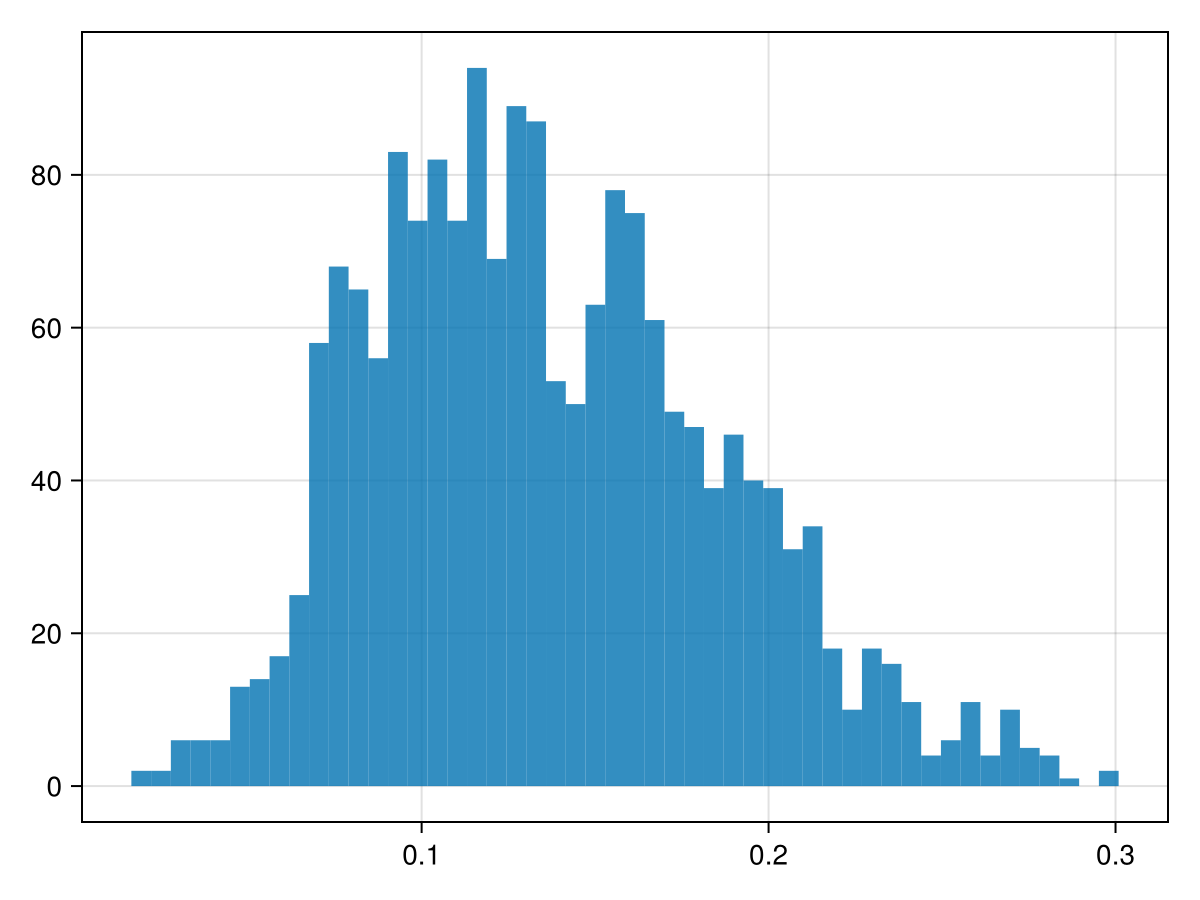

In [242]:
println(quantile(sum(w_opt.*returns_trimmed),0.25))
hist(sum(w_opt.*returns_trimmed); bins=50)

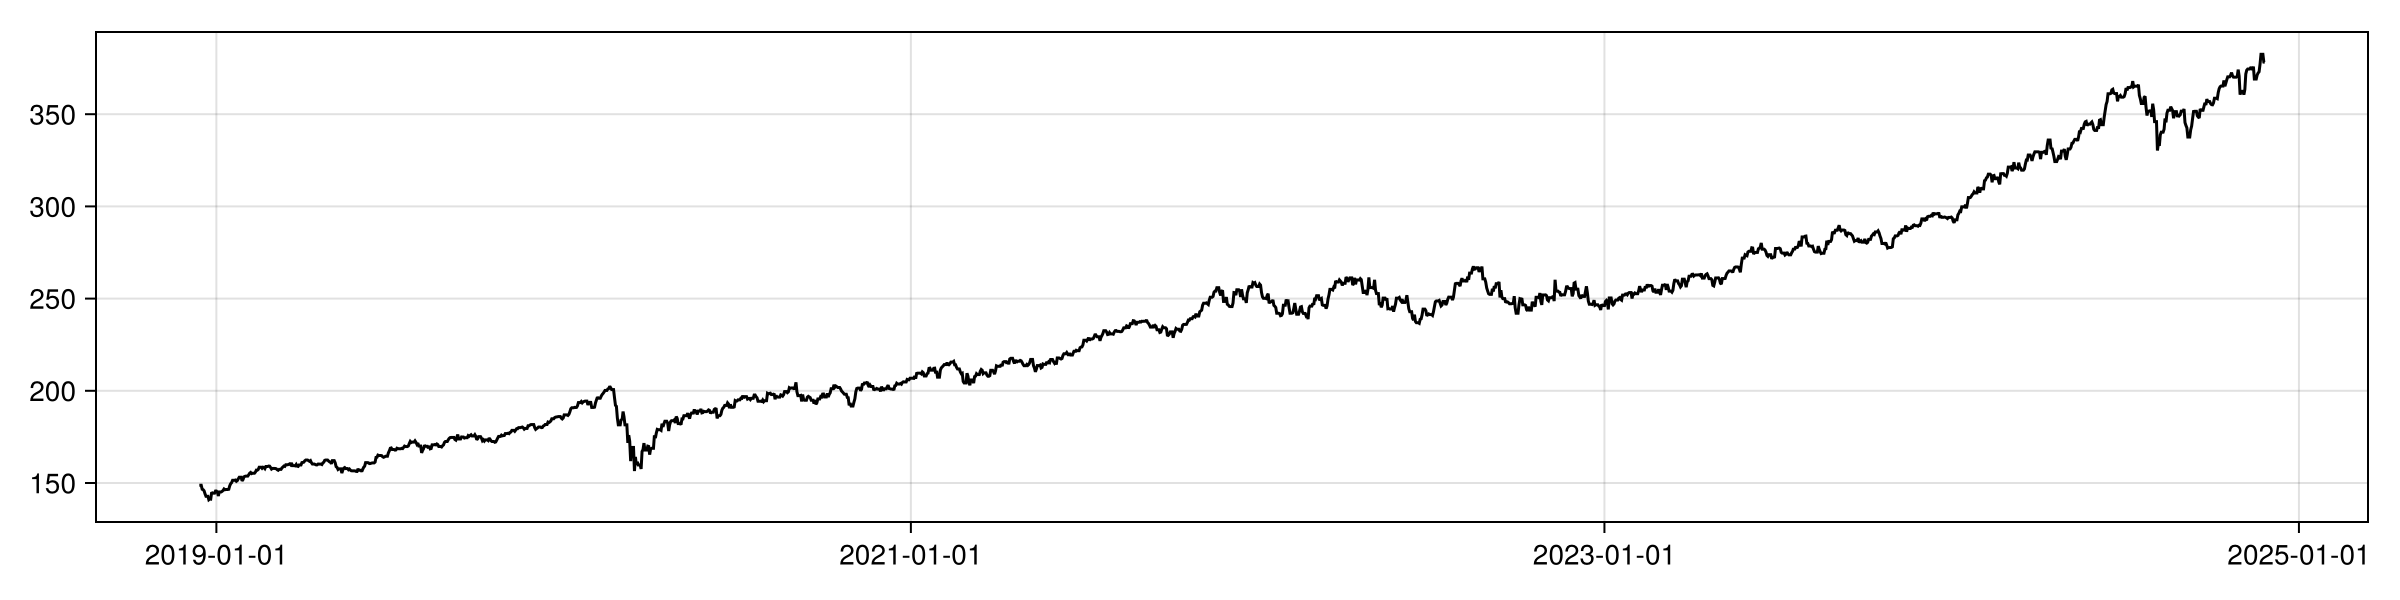

In [243]:

vals_trimmed=copy(vals)

for i in 1:length(tickers)
    first=findfirst(x->x==dates_trimmed[1][1],dates[i])
    last=findfirst(x->x==dates_trimmed[1][end],dates[i])
    vals_trimmed[i]=vals_trimmed[i][first:last]
end

fig=Figure(;size=(1200,300))
ax=Axis(fig[1,1])
lines!(ax,dates_trimmed[1][1:end],sum(w_opt.*vals_trimmed), color=:black)
fig